In [1]:
import argparse
import torch
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset_builder, load_dataset, load_from_disk
from torch.utils.data import Dataset, DataLoader
import os
import json
from tensorboardX import SummaryWriter
from tqdm.notebook import tqdm
import random
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from collections import defaultdict

from finetune import CloneDetector

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Functions

In [2]:
def find_threshold(scores, labels, metric='f1'):
    # metric: 'acc' or 'f1'

    for label in labels:
        assert abs(label - 1) < 1e-10 or abs(label) < 1e-10
    assert metric in ['acc', 'f1']

    arr = sorted(list(zip(scores, labels)), key=lambda x: x[0])

    pre = 0.0
    post = sum(labels)

    max_eval, best_threshold = 0.0, arr[0][0]
    for i in range(len(arr) - 1):
        pre += arr[i][1]
        post -= arr[i][1]

        tp = post
        fp = len(arr) - i - post
        fn = pre
        tn = (i-pre)

        acc = (tp + tn) / len(arr)
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = 2 * precision * recall / (precision + recall)

        eval = {'acc': acc, 'f1': f1}

        if max_eval < eval[metric]:
            max_eval = acc
            best_threshold = (arr[i][0] + arr[i][1]) / 2
    return best_threshold

def accuracy(scores, labels, threshold):
    return np.mean(((scores > threshold).astype(np.int32) == labels).astype(np.float32)).tolist()


def f1_score(scores, labels, threshold):
    return metrics.f1_score((scores > threshold), labels)
    
class AugmentedDataset(Dataset):
    def __init__(self, inputs):
        self.data = inputs

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    


# Load Model

In [3]:
%%time


model_name = "microsoft/codebert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
batch_size = 8

def tokenize(code):
    return tokenizer(code, return_tensors="pt", truncation=True, padding="longest", max_length=512)

def collate_fn(items):
    x = {}

    code1, code2, labels = [], [], []
    for item in items:
        code1.append(item['code1'])
        code2.append(item['code2'])
        labels.append(item['similar'])

    x['code1'] = tokenize(code1)
    x['code2'] = tokenize(code2)
    x['labels'] = torch.tensor(labels, dtype=torch.float32)

    return x



ckpt_path = '/mnt/ssd/696ds/checkpoints/0326_codebert-base_lr3.0e-07-w5000/step200000.pt'
# model = CloneDetector(model_name, device)
model = torch.load(ckpt_path).to(device)
model.device = device
model.train(False)

CPU times: user 1.79 s, sys: 943 ms, total: 2.73 s
Wall time: 2.91 s


CloneDetector(
  (model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,

# CodeSearchNet Data

In [4]:
%%time
data_dir = "/mnt/ssd/696ds_data/CodeSearchNet/resources/data/python/augmented/train/python_train_0/040223"
print(os.listdir(data_dir))
data_path = os.path.join(data_dir, "augmented_['0.2', '0.5', '0.7', '1.0'].json")
with open(data_path, 'r') as f:
    json_data = json.load(f)
    print(type(json_data))
data = json_data['data']
    

["augmented_['0.2', '0.5', '0.7', '1.0'].json"]
<class 'dict'>
CPU times: user 2.13 s, sys: 425 ms, total: 2.55 s
Wall time: 2.53 s


In [5]:
n_cs = 10000
threshold = 3.5
targets = ['0.2', '0.5', '0.7', '1.0']
p2index = {p: i for i, p in enumerate(targets)}

results = {}
for p in ['0.2', '0.5', '0.7', '1.0']:
    index = p2index[p]
    original_datapoints = []
    augmented_datapoints = []
    for i in range(len(data)):
        j = random.randint(0, len(data) - 1)
        while j == i:
            j = random.randint(0, len(data) - 1)
        
        if len(original_datapoints) == n_cs:
            break
            
        original_datapoints.append(
            {
                'code1': data[i]['original']['code'],
                #             'code2': data[j]['augmented'][index]['code'],
                'code2': data[j]['original']['code'],
                'similar': 0
            }
        )

        augmented_datapoints.append(
            {
                'code1': data[i]['augmented'][index]['code'],
                #             'code2': data[j]['augmented'][index]['code'],
                'code2': data[j]['original']['code'],
                'similar': 0
            }
        )

        if i + 1 == n_cs:
            break

    original_dataset = AugmentedDataset(original_datapoints)
    original_dataloader = DataLoader(original_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    augmented_dataset = AugmentedDataset(augmented_datapoints)
    augmented_dataloader = DataLoader(augmented_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    scores1 = []
    for i, batch in enumerate(original_dataloader):
        scores = model(batch).to('cpu')

        scores = scores.tolist()
        scores1 += scores if type(scores) == list else [scores]

    scores2 = []
    for i, batch in enumerate(augmented_dataloader):
        scores = model(batch).to('cpu')

        scores = scores.tolist()
        scores2 += scores if type(scores) == list else [scores]
        
    scores1, scores2 = np.array(scores1), np.array(scores2)

    acc1 = accuracy(scores1, np.zeros(len(scores1)), threshold)
    acc2 = accuracy(scores2, np.zeros(len(scores2)), threshold)

    _results = {
        'Accuracy1': acc1,
        'Accuracy2': acc2,
        'Mean1': np.mean(scores1),
        'Mean2': np.mean(scores2),
        'Standard Deviation1': np.std(scores1),
        'Standard Deviation2': np.std(scores2),
        'Same Prediction': np.mean((scores1 > threshold) == (scores2 > threshold)),
        'Mean Absolute Difference': np.mean(np.abs(scores1 - scores2)),
        'Root Mean Squared Difference': np.sqrt(np.mean((scores1 - scores2) ** 2))
    }

    print('p:', p)
    for key, value in _results.items():
        print(f"{key:<30}: {value:>3.3f}")
    print()
    
    results[p] = _results


p: 0.2
Accuracy1                     : 0.990
Accuracy2                     : 0.991
Mean1                         : 1.392
Mean2                         : 1.369
Standard Deviation1           : 0.987
Standard Deviation2           : 0.984
Same Prediction               : 0.999
Mean Absolute Difference      : 0.071
Root Mean Squared Difference  : 0.130

p: 0.5
Accuracy1                     : 0.984
Accuracy2                     : 0.988
Mean1                         : 1.396
Mean2                         : 1.341
Standard Deviation1           : 1.010
Standard Deviation2           : 0.996
Same Prediction               : 0.995
Mean Absolute Difference      : 0.138
Root Mean Squared Difference  : 0.219

p: 0.7
Accuracy1                     : 0.987
Accuracy2                     : 0.989
Mean1                         : 1.392
Mean2                         : 1.313
Standard Deviation1           : 0.996
Standard Deviation2           : 0.979
Same Prediction               : 0.996
Mean Absolute Difference   

In [6]:

targets = targets
x = [float(target) for target in targets]

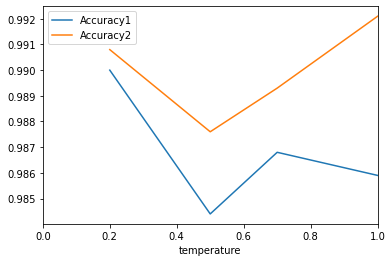

In [7]:
plt.plot(x, [results[p]['Accuracy1'] for p in targets], label='Accuracy1')
plt.plot(x, [results[p]['Accuracy2'] for p in targets], label='Accuracy2')
plt.xlabel('temperature')
plt.xlim((0.0, 1.0))
plt.legend()
plt.show()

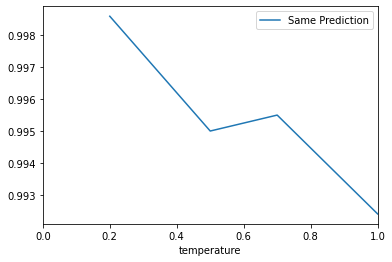

In [8]:

plt.plot(x, [results[p]['Same Prediction'] for p in targets], label='Same Prediction')
plt.xlabel('temperature')
plt.xlim((0.0, 1.0))
plt.legend()
plt.show()

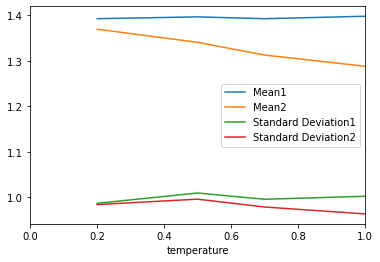

In [9]:

plt.plot(x, [results[p]['Mean1'] for p in targets], label='Mean1')
plt.plot(x, [results[p]['Mean2'] for p in targets], label='Mean2')
plt.plot(x, [results[p]['Standard Deviation1'] for p in targets], label='Standard Deviation1')
plt.plot(x, [results[p]['Standard Deviation2'] for p in targets], label='Standard Deviation2')
plt.xlabel('temperature')
plt.xlim((0.0, 1.0))
plt.legend()
plt.show()


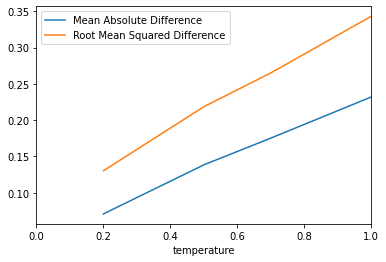

In [10]:

plt.plot(x, [results[p]['Mean Absolute Difference'] for p in targets], label='Mean Absolute Difference')
plt.plot(x, [results[p]['Root Mean Squared Difference'] for p in targets], label='Root Mean Squared Difference')
plt.xlabel('temperature')
plt.xlim((0.0, 1.0))
plt.legend()
plt.show()